# Coupled FHN model

In this notebook we want to explore coupled, excitable FitzHugh-Nagumo systems. First, in the context of spatial neares-neighbour, diffusion-like coupling of cells in the heart. And second, coupled on a random, directed network like neurons in the brain.

The general model is composed of two variables at each cell $i$, the (fast) activator $u_i$ and the inhibitor $v_i$, and reads

$$
\dot{u}_i=\alpha u_i (u_i-\beta)(1-u_i) - v_i  + \sum_{j}G_{ij}u_j+\eta_i\\
\dot{v}_i=\epsilon(u_i-v_i),
$$
where $\eta_i$ is a Gaussian noise that we only apply for the brain dynamics. 
Note that the parameters $\alpha$, $\beta$, and $\epsilon$ are homogeneous across cells, and the (spatial) coupling is only mediated via the acivators $u_i$.

In [1]:
import numpy as np 
import scipy as sp
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# import sparse matrices
from scipy.sparse import csr_matrix

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, ControlTerm, ShARK, MultiTerm, VirtualBrownianTree
import diffrax
import lineax


import jax
from jax import lax, vmap, jit
import jax.random as jr
from jax.experimental import sparse
import pickle

In [2]:
## Run only if you have installed jax with cuda and there is a GPU in your machine but you anyway want to use the CPU instead 
jax.config.update('jax_platform_name', 'cpu')
# before execute any computation / allocation
print(jax.numpy.ones(3).device)

TFRT_CPU_0


## Nullclines and Parameter Exploration

In [2]:
def FHN(t, y, return_nullclines=False):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]
    du = a*u*(u-b)*(1-u) + G.dot(u) - v
    dv = e*(u-v)
    return np.append(du,dv)

For the parameters of the 1 cell system I found from the Parltz book:
aState space of the FitzHugh-Nagumo model (2.6) for a = 3, b = 0.2, I = 0 and ε = 0.01.
At the intersection of the nullclines nu (u) = au(u − b)(1 − u) (green dotted curve) and nw(u) = u
(orange dashed line) a stable fixed point(0, 0) exists. b A perturbation pushing the system state to an
initial condition at (0.19, 0) results in a trajectory that immediately returns to the fixed point (cyan
curve), while a perturbation above threshold (0.21, 0) leads to an excursion before the orbit (purple
curve) returns to the origin 
e For a = 8, b = 0.2, I = 0 and
ε = 0.01 the nullclines intersect at two points and the system is bistable. f With a = 3, b = −0.05,
I0 = 0 and ε = 0.01 the fixed point at the origin becomes unstable and a stable limit cycle occurs
(here shown as a purple trajectory starting at (0, 0.1) and converging to the periodic attractor)

(-0.6, 1.2)

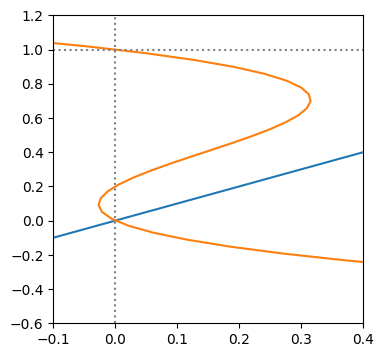

In [3]:
u_array = np.linspace(-1,3,100)
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(u_array,u_array)
e = 0.05 
a, b = (3, 0.2)
ax.plot(a*u_array*(u_array-b)*(1-u_array), u_array)
ax.axvline(0, c='grey', ls=':')
ax.axhline(1, c='grey', ls=':')
ax.set_xlim(-0.1,.4)
ax.set_ylim(-.6,1.2)

# Spatial Coupling (🫀)

In [4]:
#alternative laplacian to be checked

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks

In [5]:
def FHN_graph(t, y, args):
    N, a, b, e, Du, L,_ = args 
    u = y[:N]
    v = y[N:]
    
    du = a*u*(u-b)*(1-u) + Du*(L@u) - v 
    dv = e*(u-v)

    return jnp.append(du,dv)

def FHN_graph_noise(t, y, args):
    N, _, _, _, _,_, noise_amp = args 
    noise = noise_amp*jnp.ones((2*N))
    noise = noise.at[N:].set(0)
    return lineax.DiagonalLinearOperator(noise)

In [6]:
N_x=200
N_y=200
N=N_x*N_x

@jax.jit
def solve_heart(L,c1,y0='wave',a=3, b=0.2, e=1e-2, Du=0.2,T=1000, noise_amp=.1, max_steps=1000000, solver=ShARK(),rtol=1e-2, atol=1e-4,dt0=1e-3, noise_tol=1e-6, pcoeff=0.1, icoeff=0.3, dcoeff=0):
    if type(y0) == str and y0=='zeros':
        y0 = jnp.zeros(2*N)
    
    if type(y0) == str and y0=='random':
        y0 = jnp.random.gaussian()
    
    if type(y0) == str and y0 == 'wave':
        y0 = jnp.zeros(2 * N)
        c1_flat = jnp.logical_not(c1.flatten())
        y0 = y0.at[0:N_x].set(c1_flat[0:N_x]*0.1)
        #
        #for i in range(N):
        #    if i % N_x == 0 and not c1_flat[i]:
        #        y0 = y0.at[i].set(0.1)

    deterministic_term = ODETerm(FHN_graph)
    brownian_path = VirtualBrownianTree(0., T, tol=noise_tol, shape=(2*N,), key=jr.PRNGKey(0),levy_area=diffrax.SpaceTimeLevyArea)
    noise_term = ControlTerm(FHN_graph_noise,brownian_path)
    terms = MultiTerm(deterministic_term, noise_term)

    saveat = SaveAt(ts=jnp.linspace(0, T, 1000))
    stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol, pcoeff=pcoeff, dcoeff=dcoeff, icoeff=icoeff)

    sol = diffeqsolve(terms, solver, 0, T, dt0, y0, args=(N,a,b,e,Du,L, noise_amp), saveat=saveat,max_steps=max_steps, progress_meter=diffrax.TqdmProgressMeter(), stepsize_controller=stepsize_controller)
    return sol

In [7]:
N=N_x*N_x
L1, c1=generate_laplacian(N_x, N_x, conduction_block_threshold=0.5,sparse_matrix=True, seed=2)

In [8]:
sol = solve_heart(T=3000,a=3,b=0.05,Du=-0.04, L=L1,c1=c1, noise_amp=1e-4)

100.00%|██████████| [00:34<00:00,  2.90%/s]


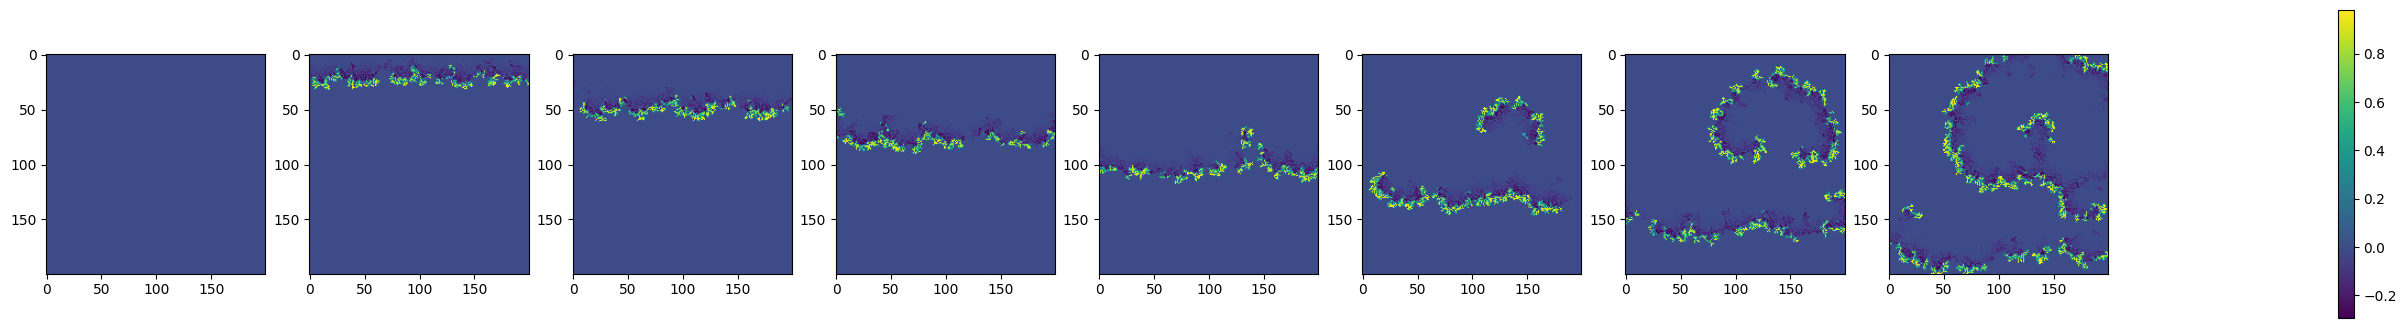

In [9]:
fig, axs = plt.subplots(1,9,figsize=(30,4))
min = sol.ys.min()
max = sol.ys.max()
for i, ax in enumerate(axs[:-1]):
    im = ax.imshow(sol.ys[int((i/len(axs)*len(sol.ts))),:N].reshape(N_x,N_y), vmin=min,vmax=max)
axs[-1].axis('off')
fig.colorbar(im, ax=axs[-1])